In [5]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_transbench101_micro'

In [6]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [8]:
dataset = 'class_object'
proxy = 'nwot'
data = dfs[dataset]

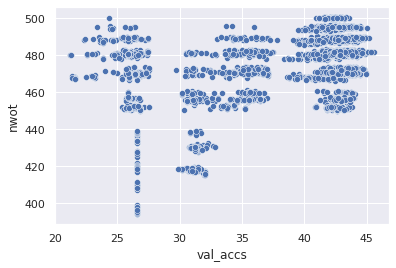

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.scatterplot(data=data, x='val_accs', y=proxy)
#plt.xlim(70, 91)
#plt_ylim(proxy)
plt.show()

In [12]:
from zc_combine.operations import parse_ops_nb201, count_all_ops

count_set = {2, 3}
ops = parse_ops_nb201(data)
count_all_ops(data, ops, count_set)

In [13]:
# TNB101_micro op names and edge indices to edges for convenience
# Op indices for zero and identity are 0, 1, in NB201 they are 1, 0
OP_NAMES = ["Zero", "Identity", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['none', 'skip_connect', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

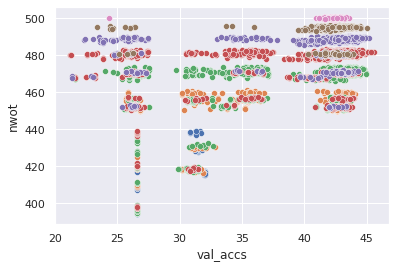

In [21]:
from zc_combine.operations import plot_clouds

plot_clouds(data, (2,3), proxy, vmax=7)
#plt_ylim(proxy)
plt.show()

Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

But, accuracy seems to depend on it a bit!

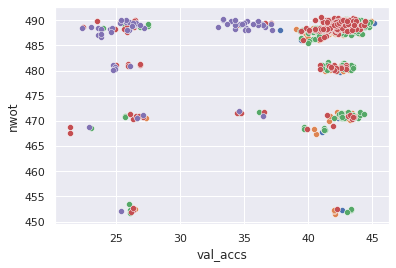

In [41]:
zoom = 4

data_zoom = data[data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=5)
#plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

Similar to NAS-Bench-201, there is some regularity in different score values:
- nets in the lowest cluster have inactive edges (1,2) and (1,3)
- nets in the second lowest cluster have inactive edge (1,2)
- nets in the second highest cluster have either inactive edge (1,2) and no other inactive, or have inactive both (1,3) and (1,4)
- nets in the highest cluster never have the highest edge inactive

In [42]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_0 = get_op_array(filter_by_range(data_zoom, proxy, 450, 465))
ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 465, 475))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 475, 483))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 483, 500))

In [44]:
np.unique(ops_0[:, 0]), np.unique(ops_0[:, 1])

(array([0]), array([0]))

In [26]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([0]), array([1, 2, 3]))

In [35]:
ops_2[ops_2[:, 0] != 0]

array([[3, 0, 0, 2, 3, 2],
       [2, 0, 0, 3, 2, 2],
       [3, 0, 0, 3, 3, 2],
       [3, 0, 0, 2, 3, 3],
       [2, 0, 0, 3, 3, 2],
       [2, 0, 0, 2, 2, 3],
       [2, 0, 0, 3, 2, 3],
       [3, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 3, 3],
       [3, 0, 0, 3, 3, 3],
       [2, 0, 0, 3, 3, 3],
       [2, 0, 0, 2, 3, 2],
       [3, 0, 0, 3, 2, 2],
       [3, 0, 0, 2, 2, 3],
       [3, 0, 0, 3, 2, 3]])

In [27]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([0, 2, 3]), array([0, 2, 3]))

In [28]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([1, 2, 3]), array([0, 1, 2, 3]))

## Conclusion
NASWOT score has problems on other datasets than CIFAR-10 as well.